In [1]:
from PORTAL import DualGuidePORTAL
from PORTAL_viz import plot_half_matrices
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import pearsonr

In [2]:
cdict = {'red':((0.0,0.125,0.125),
                (0.5,0.0,0.0),
                (1.0,0.957,0.957)),
        'green':((0.0,0.713,0.713),
                (0.5,0.0,0.0),
                (1.0,0.918,0.918)),
        'blue': ((0.0,0.886,0.886),
                (0.5,0.0,0.0),
                (1.0,0.094,0.094))}
blue_yellow = matplotlib.colors.LinearSegmentedColormap('BlueYellow',cdict)
blue_yellow.set_bad((.9, .9, .9, 1.0))
matplotlib.colormaps.register(cmap=blue_yellow)

In [3]:
sns.set_context('paper')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.title_fontsize'] = 14

In [4]:
import pickle
with open('/data1/normantm/angel/Pscreen_data/K562_AP1_816_puro/puro_AP1_screen_Final.pkl', 'rb') as f:
    puro_AP1_screen = pickle.load(f)

In [5]:
umi_filepath = "/data1/normantm/angel/Pscreen_data/K562_AP1_816_puro/all_combined_UMI_counts.csv"
viral_rep_filepath = "/data1/normantm/angel/Pscreen_data/K562_AP1_816_puro/viral_representations.csv"

In [6]:
umi_df = pd.read_csv(umi_filepath)

In [7]:
all_lineages = umi_df[['p1_identity', 'p2_identity', 'barcode_mapped', 'rep']].drop_duplicates()

In [8]:
# split all lineages into two replicates
sampled_rep1 = all_lineages.sample(frac=0.5, replace=False, random_state=0)
sampled_rep2 = all_lineages.drop(sampled_rep1.index)

In [9]:
rep1_all_lineages = sampled_rep1[['p1_identity', 'p2_identity', 'barcode_mapped', 'rep']].drop_duplicates()
rep2_all_lineages = sampled_rep2[['p1_identity', 'p2_identity', 'barcode_mapped', 'rep']].drop_duplicates()

In [10]:
# downsample and run analysis
n_lineages = [5, 10, 15, 20, 30]
random_states = np.arange(5)

screens = {n: {s: {} for s in random_states} for n in n_lineages}
original_corrcoefs = {n: [] for n in n_lineages}
pcp_corrcoefs = {n: [] for n in n_lineages}

for state in tqdm(random_states):
    for n in tqdm(n_lineages):
        rep1_sampled_lineages = rep1_all_lineages.sample(816**2*n, replace=False, random_state=state)
        rep2_sampled_lineages = rep2_all_lineages.sample(816**2*n, replace=False, random_state=state)

        rep1_df = umi_df.set_index(["p1_identity", "p2_identity", "barcode_mapped", "rep"]).loc[
            rep1_sampled_lineages.set_index(["p1_identity", "p2_identity", "barcode_mapped", "rep"]).index
            ].reset_index()
        rep2_df = umi_df.set_index(["p1_identity", "p2_identity", "barcode_mapped", "rep"]).loc[
            rep2_sampled_lineages.set_index(["p1_identity", "p2_identity", "barcode_mapped", "rep"]).index
            ].reset_index()

        screens[n][state]["rep1"] = DualGuidePORTAL(rep1_df,
                                       input_rep_data=viral_rep_filepath,
                                       sample_columns=["sample", "rep"])
        screens[n][state]["rep2"] = DualGuidePORTAL(rep2_df,
                                       input_rep_data=viral_rep_filepath,
                                       sample_columns=["sample", "rep"])
        screens[n][state]["rep1"].run_standard_analysis(gi_kind="joint", perform_pcp=True, keep_single_values=False)
        screens[n][state]["rep2"].run_standard_analysis(gi_kind="joint", perform_pcp=True, keep_single_values=False)

        original_corrcoefs[n].append(pearsonr(screens[n][state]["rep1"].z_reporter_GI.fillna(0).stack().values,
                                                             screens[n][state]["rep2"].z_reporter_GI.fillna(0).stack().values)[0])
        pcp_corrcoefs[n].append(pearsonr(screens[n][state]["rep1"].z_reporter_GI_pcp.fillna(0).stack().values,
                                                        screens[n][state]["rep2"].z_reporter_GI_pcp.fillna(0).stack().values)[0])

  0%|                                                        | 0/5 [00:00<?, ?it/s]

Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=1.0084, repr2=1.0290
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.99129148e-01  2.34718349e+12  4.81553970e+12 -5.87298407e+12
   2.55790163e+11  2.55790163e+11  2.55790163e+11 -2.21256604e+12
  -2.21256604e+12 -2.21256604e+12  8.47595772e+12  8.47595772e+12
   8.47595772e+12]]
Intercept: [-2.60297366e+12]
R^2 score: 0.5749796486087878
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021758:   8%|█▉                        | 375/5000 [01:39<20:21,  3.79it/s]


Converged in 375 iterations


Res: 0.00021146:   5%|█▍                        | 266/5000 [01:08<20:20,  3.88it/s]


Converged in 266 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=1.0077, repr2=1.0283
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 7.26618632e-01 -6.65620736e+12 -4.58015242e+12  2.90642600e+12
  -9.47138597e+10 -9.47138597e+10 -9.47138597e+10 -2.17076879e+12
  -2.17076879e+12 -2.17076879e+12 -9.65734722e+12 -9.65734722e+12
  -9.65734722e+12]]
Intercept: [6.75092122e+12]
R^2 score: 0.5853926932006168
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021415:   8%|██                        | 408/5000 [01:34<17:38,  4.34it/s]


Converged in 408 iterations


Res: 0.00021737:   5%|█▎                        | 257/5000 [00:58<18:04,  4.38it/s]


Converged in 257 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 20%|█████████▍                                     | 1/5 [10:04<40:17, 604.27s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.6177, repr2=0.6497
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.79356570e-01  2.71286839e+12  4.62707801e+12  1.64968281e+12
   4.52014943e+10  4.52014943e+10  4.52014943e+10 -1.86900812e+12
  -1.86900812e+12 -1.86900812e+12  1.10838707e+12  1.10838707e+12
   1.10838707e+12]]
Intercept: [-2.75806989e+12]
R^2 score: 0.511501157756289
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021262:   9%|██▎                       | 441/5000 [01:56<20:08,  3.77it/s]


Converged in 441 iterations


Res: 0.00021091:   6%|█▋                        | 320/5000 [01:26<21:07,  3.69it/s]


Converged in 320 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.6179, repr2=0.6499
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.66056033e-01 -4.63398876e+13 -6.68797787e+13 -4.45655577e+13
  -6.90463656e+12 -6.90463656e+12 -6.90463656e+12  1.36352545e+13
   1.36352545e+13  1.36352545e+13 -8.67896644e+12 -8.67896644e+12
  -8.67896644e+12]]
Intercept: [5.32445242e+13]
R^2 score: 0.5067556339344466
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021027:   9%|██▍                       | 461/5000 [01:55<18:59,  3.98it/s]


Converged in 461 iterations


Res: 0.00020708:   6%|█▋                        | 323/5000 [01:15<18:12,  4.28it/s]


Converged in 323 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 40%|██████████████████▊                            | 2/5 [22:53<35:03, 701.09s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.4476, repr2=0.4776
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.65888391  0.00883577 -0.01770807  0.0088723   0.00783684 -0.03054659
   0.03154552 -0.02003251 -0.01157427  0.01389871 -0.04137426  0.01720914
   0.03303742]]
Intercept: [1.20415367]
R^2 score: 0.48544474070537125
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021239:   9%|██▍                       | 458/5000 [02:00<19:52,  3.81it/s]


Converged in 458 iterations


Res: 0.00022589:   6%|█▌                        | 305/5000 [01:13<18:55,  4.13it/s]


Converged in 305 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.4476, repr2=0.4779
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.38769568e-01  2.45050642e+13  6.00064418e+12  1.72665276e+13
  -1.04273052e+13 -1.04273052e+13 -1.04273052e+13  8.07711486e+12
   8.07711486e+12  8.07711486e+12 -3.18876858e+12 -3.18876858e+12
  -3.18876858e+12]]
Intercept: [-1.4077759e+13]
R^2 score: 0.46966068253940063
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00020964:   9%|██▎                       | 455/5000 [01:43<17:09,  4.41it/s]


Converged in 455 iterations


Res: 0.00022829:   6%|█▌                        | 295/5000 [01:04<17:03,  4.60it/s]


Converged in 295 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 60%|████████████████████████████▏                  | 3/5 [36:48<25:25, 762.63s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.3534, repr2=0.3800
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.62734210e-01 -5.84732087e+12 -6.45508582e+12 -2.72777392e+12
   4.11741944e+10  4.11741944e+10  4.11741944e+10  6.48939150e+11
   6.48939150e+11  6.48939150e+11 -3.07837275e+12 -3.07837275e+12
  -3.07837275e+12]]
Intercept: [5.80614667e+12]
R^2 score: 0.48780160500265146
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00020860:  10%|██▌                       | 482/5000 [01:27<13:38,  5.52it/s]


Converged in 482 iterations


Res: 0.00026085:   5%|█▍                        | 267/5000 [00:46<13:50,  5.70it/s]


Converged in 267 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.3533, repr2=0.3800
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.64470479  0.00983096 -0.0217348   0.01190384  0.00881434 -0.03940307
   0.04041969 -0.003974   -0.01039504 -0.00736576 -0.04508391  0.02757986
   0.02940789]]
Intercept: [1.25699188]
R^2 score: 0.4770657858446027
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00020814:  10%|██▌                       | 483/5000 [01:35<14:54,  5.05it/s]


Converged in 483 iterations


Res: 0.00025439:   6%|█▍                        | 275/5000 [01:06<19:08,  4.11it/s]


Converged in 275 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 80%|█████████████████████████████████████▌         | 4/5 [51:23<13:26, 806.78s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.2517, repr2=0.2727
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.6511743   0.00734448 -0.02016112  0.01281664  0.00523113 -0.0331543
   0.03526766 -0.01666583 -0.00566448  0.00216918 -0.04245084  0.01656841
   0.03869906]]
Intercept: [1.23272597]
R^2 score: 0.4830311013871832
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00022853:   8%|██▏                       | 421/5000 [01:21<14:44,  5.17it/s]


Converged in 421 iterations


Res: 0.00026357:   6%|█▍                        | 283/5000 [00:55<15:23,  5.11it/s]


Converged in 283 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.2516, repr2=0.2726
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.33462324e-01  6.01549405e+11  2.14099443e+12  1.95595220e+11
   4.09517620e+11  4.09517620e+11  4.09517620e+11 -1.12992741e+12
  -1.12992741e+12 -1.12992741e+12  8.15471805e+11  8.15471805e+11
   8.15471805e+11]]
Intercept: [-1.01106702e+12]
R^2 score: 0.464461243334369
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00022964:   8%|██                        | 402/5000 [01:17<14:49,  5.17it/s]


Converged in 402 iterations


Res: 0.00026063:   6%|█▌                        | 297/5000 [00:57<15:05,  5.19it/s]


Converged in 297 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 20%|████████▍                                 | 1/5 [1:08:47<4:35:10, 4127.66s/it]


Analysis complete!



  0%|                                                        | 0/5 [00:00<?, ?it/s]

Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=1.0086, repr2=1.0292
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 7.42845245e-01 -2.04128712e+12 -5.28503383e+12  5.03905258e+12
  -1.05925659e+12 -1.05925659e+12 -1.05925659e+12  2.18449011e+12
   2.18449011e+12  2.18449011e+12 -8.13959629e+12 -8.13959629e+12
  -8.13959629e+12]]
Intercept: [3.10054371e+12]
R^2 score: 0.5960618365251427
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021131:   8%|██                        | 402/5000 [01:19<15:14,  5.03it/s]


Converged in 402 iterations


Res: 0.00020706:   5%|█▍                        | 271/5000 [00:50<14:41,  5.36it/s]


Converged in 271 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=1.0089, repr2=1.0284
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.87115818e-01  6.17868157e+12  1.02648331e+13  2.59751708e+12
   1.78792332e+12  1.78792332e+12  1.78792332e+12 -2.29822822e+12
  -2.29822822e+12 -2.29822822e+12  5.36908781e+12  5.36908781e+12
   5.36908781e+12]]
Intercept: [-7.96660489e+12]
R^2 score: 0.5429237036457474
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021978:   7%|█▊                        | 355/5000 [00:59<13:03,  5.93it/s]


Converged in 355 iterations


Res: 0.00020437:   6%|█▍                        | 284/5000 [00:52<14:28,  5.43it/s]


Converged in 284 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 20%|█████████▍                                     | 1/5 [08:41<34:47, 521.76s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.6181, repr2=0.6500
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.69504877  0.01317107 -0.01607512  0.00290406  0.016943   -0.03802072
   0.03424879 -0.01541637  0.01020591 -0.01086467 -0.03729142  0.01828959
   0.02190588]]
Intercept: [1.06633825]
R^2 score: 0.5375823168464294
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021162:   9%|██▎                       | 445/5000 [01:26<14:48,  5.13it/s]


Converged in 445 iterations


Res: 0.00021318:   6%|█▌                        | 302/5000 [00:58<15:17,  5.12it/s]


Converged in 302 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.6181, repr2=0.6497
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.6604697   0.01809951 -0.01580237 -0.00229714  0.00523828 -0.02907871
   0.04193994 -0.02771455  0.00890147  0.00301072 -0.05830487  0.02608621
   0.02992152]]
Intercept: [1.19840023]
R^2 score: 0.49333850629712006
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021132:   8%|██▏                       | 423/5000 [01:16<13:45,  5.55it/s]


Converged in 423 iterations


Res: 0.00020814:   6%|█▌                        | 312/5000 [00:53<13:24,  5.83it/s]


Converged in 312 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 40%|██████████████████▊                            | 2/5 [19:28<29:45, 595.05s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.4477, repr2=0.4779
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.6638328   0.00598032 -0.02045577  0.01447546  0.012942   -0.04000788
   0.0330462  -0.01512608 -0.00226628 -0.00306341 -0.03572145  0.02216961
   0.0280273 ]]
Intercept: [1.18608692]
R^2 score: 0.5000247076248536
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00022700:   9%|██▏                       | 427/5000 [01:24<15:01,  5.07it/s]


Converged in 427 iterations


Res: 0.00022727:   6%|█▌                        | 296/5000 [00:59<15:43,  4.99it/s]


Converged in 296 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.4476, repr2=0.4776
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.64176177  0.01157836 -0.0143774   0.00279904  0.00511196 -0.03732266
   0.04378906 -0.02136439  0.00188436  0.00510264 -0.05548168  0.02746819
   0.03081253]]
Intercept: [1.26308567]
R^2 score: 0.47831128404780787
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00020911:   9%|██▍                       | 457/5000 [01:31<15:08,  5.00it/s]


Converged in 457 iterations


Res: 0.00023469:   6%|█▍                        | 285/5000 [00:56<15:34,  5.05it/s]


Converged in 285 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 60%|████████████████████████████▏                  | 3/5 [32:08<22:20, 670.37s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.3533, repr2=0.3801
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.66108464  0.00558674 -0.02165946  0.01607272  0.00613592 -0.03241289
   0.0318637  -0.01627434 -0.00354262 -0.0018425  -0.04198406  0.02429735
   0.03375942]]
Intercept: [1.19432934]
R^2 score: 0.49653822829328975
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00022607:   9%|██▏                       | 432/5000 [01:24<14:54,  5.11it/s]


Converged in 432 iterations


Res: 0.00023605:   6%|█▌                        | 302/5000 [00:50<13:10,  5.94it/s]


Converged in 302 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.3533, repr2=0.3799
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.35880201e-01  1.61769781e+13  9.47281566e+12  1.01563844e+13
  -3.25110189e+12 -3.25110189e+12 -3.25110189e+12  3.45306058e+12
   3.45306058e+12  3.45306058e+12  2.76949189e+12  2.76949189e+12
   2.76949189e+12]]
Intercept: [-1.29258762e+13]
R^2 score: 0.4621023089945604
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021254:   9%|██▎                       | 454/5000 [01:18<13:09,  5.76it/s]


Converged in 454 iterations


Res: 0.00026041:   5%|█▍                        | 270/5000 [00:47<13:52,  5.68it/s]


Converged in 270 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 80%|█████████████████████████████████████▌         | 4/5 [46:00<12:14, 734.29s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.2516, repr2=0.2726
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.58481010e-01  7.32612852e+12  5.48300412e+12  4.56102986e+12
  -5.49140918e+11 -5.49140918e+11 -5.49140918e+11  1.29398349e+12
   1.29398349e+12  1.29398349e+12  2.21595775e+12  2.21595775e+12
   2.21595775e+12]]
Intercept: [-6.77698761e+12]
R^2 score: 0.49132302506043923
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00022814:   8%|██▏                       | 420/5000 [01:20<14:39,  5.21it/s]


Converged in 420 iterations


Res: 0.00026688:   6%|█▍                        | 286/5000 [00:55<15:15,  5.15it/s]


Converged in 286 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.2517, repr2=0.2727
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.49370647e-01  1.23886535e-02 -2.03238492e-02  7.93519572e-03
   4.09008134e-03 -3.63584279e-02  4.46570000e-02 -1.19147673e-02
  -8.75202432e-03  3.42942418e-04 -5.42172078e-02  3.42684893e-02
   2.78839142e-02]]
Intercept: [1.24059257]
R^2 score: 0.4790246168468292
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00022972:   8%|██                        | 406/5000 [01:17<14:34,  5.25it/s]


Converged in 406 iterations


Res: 0.00026064:   6%|█▌                        | 293/5000 [00:55<14:54,  5.26it/s]


Converged in 293 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 40%|████████████████▊                         | 2/5 [2:12:10<3:16:50, 3936.67s/it]


Analysis complete!



  0%|                                                        | 0/5 [00:00<?, ?it/s]

Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=1.0085, repr2=1.0285
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.7394455   0.01964401 -0.03515868  0.01551467 -0.00940057 -0.01269299
   0.04173758 -0.01966401  0.00160452 -0.01709919 -0.053123    0.02151691
   0.04712076]]
Intercept: [0.92830267]
R^2 score: 0.5802644189772397
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021852:   7%|█▊                        | 349/5000 [01:07<15:01,  5.16it/s]


Converged in 349 iterations


Res: 0.00020603:   5%|█▍                        | 274/5000 [00:56<16:07,  4.88it/s]


Converged in 274 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=1.0082, repr2=1.0285
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.75116605  0.01223393 -0.02867705  0.01644313  0.02170358 -0.03845988
   0.02899022 -0.00994162 -0.00840816 -0.01032727 -0.03657348  0.04181404
   0.01120256]]
Intercept: [0.88538177]
R^2 score: 0.5905959427405155
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021395:   8%|█▉                        | 376/5000 [01:10<14:27,  5.33it/s]


Converged in 376 iterations


Res: 0.00021425:   5%|█▍                        | 270/5000 [00:53<15:39,  5.04it/s]


Converged in 270 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 20%|█████████▍                                     | 1/5 [08:43<34:55, 523.85s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.6177, repr2=0.6502
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.75797287e-01  1.28120715e+12  4.15147115e+11  1.49944588e+11
  -7.95907354e+11 -7.95907354e+11 -7.95907354e+11  7.01526787e+10
   7.01526787e+10  7.01526787e+10  3.35355205e+11  3.35355205e+11
   3.35355205e+11]]
Intercept: [-4.85299793e+11]
R^2 score: 0.5077116706974483
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00020942:   9%|██▎                       | 449/5000 [01:25<14:24,  5.26it/s]


Converged in 449 iterations


Res: 0.00020504:   6%|█▋                        | 322/5000 [01:01<14:56,  5.22it/s]


Converged in 322 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.6181, repr2=0.6498
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.69151909e-01 -2.46921731e+12 -1.00122114e+12 -5.57820088e+11
   1.26105709e+12  1.26105709e+12  1.26105709e+12 -2.06939082e+11
  -2.06939082e+11 -2.06939082e+11 -6.50340135e+11 -6.50340135e+11
  -6.50340135e+11]]
Intercept: [1.20816022e+12]
R^2 score: 0.5006873506542506
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00020644:   9%|██▎                       | 455/5000 [01:26<14:24,  5.26it/s]


Converged in 455 iterations


Res: 0.00020471:   7%|█▋                        | 326/5000 [00:57<13:43,  5.67it/s]


Converged in 326 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 40%|██████████████████▊                            | 2/5 [19:47<30:17, 605.86s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.4475, repr2=0.4778
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.54436511e-01  9.25545630e-03 -2.00247403e-02  1.07692840e-02
   6.51886743e-03 -3.45790561e-02  3.73156450e-02 -1.25923176e-02
  -7.50299690e-03  7.05741552e-05 -5.42822327e-02  2.59567846e-02
   3.90947321e-02]]
Intercept: [1.22230845]
R^2 score: 0.48722461773484316
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021062:   9%|██▍                       | 465/5000 [01:26<14:06,  5.35it/s]


Converged in 465 iterations


Res: 0.00022305:   6%|█▌                        | 311/5000 [00:58<14:49,  5.27it/s]


Converged in 311 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.4477, repr2=0.4776
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.65457942  0.01444554 -0.02312726  0.00868172  0.01919214 -0.03765915
   0.03291254 -0.01884695  0.00083605 -0.00511636 -0.05122377  0.02552326
   0.03438223]]
Intercept: [1.22326114]
R^2 score: 0.4810321707680001
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00020909:   9%|██▍                       | 457/5000 [01:28<14:37,  5.18it/s]


Converged in 457 iterations


Res: 0.00022931:   6%|█▌                        | 306/5000 [00:57<14:44,  5.31it/s]


Converged in 306 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 60%|████████████████████████████▏                  | 3/5 [32:21<22:27, 673.90s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.3533, repr2=0.3800
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.64139406  0.00913774 -0.01953894  0.0104012   0.00363482 -0.03172457
   0.0372275  -0.01670201 -0.00408152  0.00124459 -0.04773397  0.0187539
   0.03938128]]
Intercept: [1.26492155]
R^2 score: 0.48202258187038716
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021064:  10%|██▍                       | 476/5000 [01:29<14:09,  5.32it/s]


Converged in 476 iterations


Res: 0.00025551:   5%|█▍                        | 271/5000 [00:46<13:29,  5.84it/s]


Converged in 271 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.3535, repr2=0.3800
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.63941604  0.00962857 -0.02259224  0.01296367  0.00932583 -0.03687705
   0.03717979 -0.01812286 -0.0077002   0.00323083 -0.04986996  0.03218684
   0.03064679]]
Intercept: [1.2766405]
R^2 score: 0.46770829489629395
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021103:   9%|██▍                       | 469/5000 [01:26<13:58,  5.40it/s]


Converged in 469 iterations


Res: 0.00026124:   5%|█▍                        | 273/5000 [00:51<14:56,  5.27it/s]


Converged in 273 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 80%|█████████████████████████████████████▌         | 4/5 [46:18<12:17, 737.95s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.2516, repr2=0.2726
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.49191609e-01  2.73228030e+12  8.74954217e+12  1.01516085e+13
   4.08011921e+12  4.08011921e+12  4.08011921e+12 -1.93714266e+12
  -1.93714266e+12 -1.93714266e+12 -3.33920898e+12 -3.33920898e+12
  -3.33920898e+12]]
Intercept: [-6.81239951e+12]
R^2 score: 0.48520571531199097
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00022717:   9%|██▏                       | 426/5000 [01:30<16:10,  4.71it/s]


Converged in 426 iterations


Res: 0.00026557:   6%|█▍                        | 279/5000 [01:01<17:24,  4.52it/s]


Converged in 279 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.2516, repr2=0.2726
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.42476855e-01 -1.34635544e+13 -1.11249723e+13  1.98496058e+12
   3.71120018e+12  3.71120018e+12  3.71120018e+12  1.37261812e+12
   1.37261812e+12  1.37261812e+12 -1.17373148e+13 -1.17373148e+13
  -1.17373148e+13]]
Intercept: [9.75235418e+12]
R^2 score: 0.4718398152551413
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00023198:   8%|██                        | 390/5000 [01:15<14:48,  5.19it/s]


Converged in 390 iterations


Res: 0.00025938:   6%|█▌                        | 297/5000 [00:54<14:18,  5.48it/s]


Converged in 297 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 60%|█████████████████████████▏                | 3/5 [3:16:06<2:09:41, 3890.70s/it]


Analysis complete!



  0%|                                                        | 0/5 [00:00<?, ?it/s]

Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=1.0082, repr2=1.0287
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 7.18110014e-01  3.84160661e+12  1.17479507e+12 -1.21729971e+12
   8.49949383e+10  8.49949383e+10  8.49949383e+10  2.75180649e+12
   2.75180649e+12  2.75180649e+12  5.14390126e+12  5.14390126e+12
   5.14390126e+12]]
Intercept: [-3.92660155e+12]
R^2 score: 0.5494105972591113
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021346:   7%|█▉                        | 364/5000 [01:13<15:30,  4.98it/s]


Converged in 364 iterations


Res: 0.00020763:   6%|█▍                        | 277/5000 [00:53<15:11,  5.18it/s]


Converged in 277 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=1.0076, repr2=1.0282
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 7.50180167e-01 -4.56916055e+12 -4.06933398e+11 -1.13598661e+12
   2.49536157e+12  2.49536157e+12  2.49536157e+12 -1.66686559e+12
  -1.66686559e+12 -1.66686559e+12 -9.37812377e+11 -9.37812377e+11
  -9.37812377e+11]]
Intercept: [2.07379899e+12]
R^2 score: 0.5884863274776222
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021348:   8%|██                        | 386/5000 [01:17<15:30,  4.96it/s]


Converged in 386 iterations


Res: 0.00021196:   5%|█▎                        | 258/5000 [00:50<15:31,  5.09it/s]


Converged in 258 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 20%|█████████▍                                     | 1/5 [09:03<36:14, 543.55s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.6176, repr2=0.6495
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.65831106  0.0166496  -0.01844762  0.00179802  0.00846243 -0.04190432
   0.05009149 -0.00739791 -0.0156674   0.00461769 -0.04736374  0.00254629
   0.04661547]]
Intercept: [1.20397223]
R^2 score: 0.49317554006303177
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021045:   9%|██▎                       | 438/5000 [01:22<14:19,  5.31it/s]


Converged in 438 iterations


Res: 0.00020701:   6%|█▋                        | 323/5000 [01:03<15:20,  5.08it/s]


Converged in 323 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.6177, repr2=0.6499
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.66274909  0.01233681 -0.02411386  0.01177705  0.0056892  -0.04163502
   0.04828263 -0.03377916 -0.0037942   0.0134595  -0.03872805  0.02876509
   0.02174001]]
Intercept: [1.1955666]
R^2 score: 0.4972627834220612
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021267:   8%|██▏                       | 414/5000 [01:20<14:46,  5.17it/s]


Converged in 414 iterations


Res: 0.00020367:   6%|█▋                        | 323/5000 [01:04<15:36,  4.99it/s]


Converged in 323 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 40%|██████████████████▊                            | 2/5 [20:16<30:58, 619.50s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.4475, repr2=0.4776
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.45181360e-01  1.04055162e+13  1.76985417e+13  1.29744749e+13
   6.50283687e+12  6.50283687e+12  6.50283687e+12 -7.90188597e+11
  -7.90188597e+11 -7.90188597e+11  3.93387818e+12  3.93387818e+12
   3.93387818e+12]]
Intercept: [-1.69083531e+13]
R^2 score: 0.4770167678983793
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021102:   9%|██▍                       | 463/5000 [01:23<13:38,  5.54it/s]


Converged in 463 iterations


Res: 0.00020926:   7%|█▊                        | 343/5000 [01:02<14:05,  5.51it/s]


Converged in 343 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.4476, repr2=0.4778
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.66015951  0.01301838 -0.02410713  0.01108876 -0.00265748 -0.02314802
   0.03882389 -0.02433441 -0.00216646  0.00239373 -0.04021032  0.0282143
   0.02308478]]
Intercept: [1.20320766]
R^2 score: 0.482011311226612
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00020904:   9%|██▎                       | 453/5000 [01:22<13:44,  5.52it/s]


Converged in 453 iterations


Res: 0.00022708:   6%|█▌                        | 302/5000 [00:55<14:15,  5.49it/s]


Converged in 302 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 60%|████████████████████████████▏                  | 3/5 [32:49<22:40, 680.43s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.3533, repr2=0.3801
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[6.57821687e-01 3.92117951e+12 6.98080124e+12 5.80091461e+12
  3.18822124e+12 3.18822124e+12 3.18822124e+12 1.28599516e+11
  1.28599516e+11 1.28599516e+11 1.30848614e+12 1.30848614e+12
  1.30848614e+12]]
Intercept: [-7.10940075e+12]
R^2 score: 0.48351101170817934
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00020937:  10%|██▍                       | 477/5000 [01:28<14:01,  5.37it/s]


Converged in 477 iterations


Res: 0.00026521:   5%|█▎                        | 264/5000 [00:46<14:00,  5.64it/s]


Converged in 264 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.3532, repr2=0.3800
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.51790440e-01 -5.78880312e+11 -5.37757786e+11 -3.06016861e+11
   5.87244262e+10  5.87244262e+10  5.87244262e+10  1.76018995e+10
   1.76018995e+10  1.76018995e+10 -2.14139025e+11 -2.14139025e+11
  -2.14139025e+11]]
Intercept: [5.20155886e+11]
R^2 score: 0.47547237301399004
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021199:  10%|██▍                       | 478/5000 [01:28<13:53,  5.42it/s]


Converged in 478 iterations


Res: 0.00025801:   5%|█▍                        | 265/5000 [00:51<15:25,  5.12it/s]


Converged in 265 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 80%|█████████████████████████████████████▌         | 4/5 [46:50<12:24, 744.09s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.2516, repr2=0.2726
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.65486417  0.0071151  -0.016896    0.0097809   0.00968021 -0.03681519
   0.03425008 -0.0139975  -0.00359286  0.00069437 -0.04267306  0.01562729
   0.03682668]]
Intercept: [1.22067995]
R^2 score: 0.4900150553324998
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00022943:   8%|██▏                       | 417/5000 [01:17<14:15,  5.36it/s]


Converged in 417 iterations


Res: 0.00026699:   6%|█▍                        | 278/5000 [00:53<15:02,  5.23it/s]


Converged in 278 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.2516, repr2=0.2726
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.64261618  0.0077827  -0.01656544  0.00878274  0.00398218 -0.03969007
   0.0434906  -0.01589486 -0.00915128  0.0084807  -0.04798492  0.03121356
   0.0255541 ]]
Intercept: [1.26598223]
R^2 score: 0.47017410420564076
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00022872:   8%|██▏                       | 410/5000 [01:19<14:49,  5.16it/s]


Converged in 410 iterations


Res: 0.00026405:   6%|█▍                        | 287/5000 [00:54<14:52,  5.28it/s]


Converged in 287 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 80%|█████████████████████████████████▌        | 4/5 [4:20:24<1:04:37, 3877.86s/it]


Analysis complete!



  0%|                                                        | 0/5 [00:00<?, ?it/s]

Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=1.0079, repr2=1.0289
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.78255729  0.01925433 -0.01795145 -0.00130288  0.04413022 -0.06115711
   0.03628123 -0.03791593  0.01254157  0.00742291 -0.03338145  0.00467009
   0.02740848]]
Intercept: [0.75983753]
R^2 score: 0.6438821661393332
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021354:   8%|██                        | 398/5000 [01:14<14:17,  5.37it/s]


Converged in 398 iterations


Res: 0.00021588:   5%|█▎                        | 245/5000 [00:44<14:25,  5.50it/s]


Converged in 245 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=1.0084, repr2=1.0286
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.72697138 -0.00703961 -0.01617473  0.02321433 -0.00569545 -0.04927079
   0.04792664 -0.01239937 -0.00684393  0.00306857 -0.04213028  0.04292362
   0.022421  ]]
Intercept: [0.97365425]
R^2 score: 0.5633746327405162
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021101:   8%|█▉                        | 376/5000 [01:08<14:01,  5.50it/s]


Converged in 376 iterations


Res: 0.00020740:   5%|█▍                        | 265/5000 [00:54<16:18,  4.84it/s]


Converged in 265 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 20%|█████████▍                                     | 1/5 [08:56<35:47, 536.80s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.6180, repr2=0.6501
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.65726723  0.00740005 -0.01602262  0.00862257  0.01809249 -0.04268679
   0.03199436 -0.02404833  0.00086398  0.00716173 -0.05412127  0.02122423
   0.0415196 ]]
Intercept: [1.20594581]
R^2 score: 0.4997545373081086
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021070:   9%|██▏                       | 428/5000 [01:23<14:56,  5.10it/s]


Converged in 428 iterations


Res: 0.00020951:   7%|█▋                        | 328/5000 [01:12<17:18,  4.50it/s]


Converged in 328 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.6181, repr2=0.6499
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.53240949e-01  2.07020156e+13  1.94762424e+13  1.39165942e+13
  -1.13660046e+12 -1.13660046e+12 -1.13660046e+12  8.91727694e+10
   8.91727694e+10  8.91727694e+10  5.64882095e+12  5.64882095e+12
   5.64882095e+12]]
Intercept: [-1.95654152e+13]
R^2 score: 0.47278909862981444
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021328:   8%|██▏                       | 417/5000 [01:29<16:20,  4.67it/s]


Converged in 417 iterations


Res: 0.00020499:   7%|█▋                        | 329/5000 [01:00<14:23,  5.41it/s]


Converged in 329 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 40%|██████████████████▊                            | 2/5 [20:41<31:46, 635.42s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.4477, repr2=0.4778
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.64070697e-01 -1.15166367e+12 -4.96899627e+12 -1.97855592e+12
  -1.20528203e+12 -1.20528203e+12 -1.20528203e+12  2.61205057e+12
   2.61205057e+12  2.61205057e+12 -3.78389781e+11 -3.78389781e+11
  -3.78389781e+11]]
Intercept: [2.3569457e+12]
R^2 score: 0.49937136760238043
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021209:   9%|██▍                       | 462/5000 [01:25<13:57,  5.42it/s]


Converged in 462 iterations


Res: 0.00022867:   6%|█▌                        | 294/5000 [00:55<14:43,  5.33it/s]


Converged in 294 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.4477, repr2=0.4776
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.63711984  0.00461948 -0.019325    0.01470553 -0.00156066 -0.04299547
   0.0491756  -0.00578182 -0.01187636 -0.00166682 -0.04389123  0.02833614
   0.03026062]]
Intercept: [1.29011674]
R^2 score: 0.45684061976014145
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021641:   8%|██▏                       | 416/5000 [01:11<13:02,  5.86it/s]


Converged in 416 iterations


Res: 0.00022165:   6%|█▋                        | 313/5000 [00:59<14:47,  5.28it/s]


Converged in 313 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 60%|████████████████████████████▏                  | 3/5 [33:20<23:04, 692.06s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.3534, repr2=0.3801
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.65742821  0.01157935 -0.01642848  0.00484913  0.01674965 -0.03631263
   0.03114233 -0.01571651 -0.00498745  0.00427548 -0.04638223  0.01932858
   0.03190279]]
Intercept: [1.20714352]
R^2 score: 0.49355427447127653
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021255:   9%|██▍                       | 463/5000 [01:31<14:58,  5.05it/s]


Converged in 463 iterations


Res: 0.00026168:   5%|█▍                        | 266/5000 [00:50<14:53,  5.30it/s]


Converged in 266 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.3534, repr2=0.3800
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.64230294  0.00667614 -0.02115904  0.01448291  0.00873734 -0.04532922
   0.04326802 -0.012269   -0.01192169  0.00303165 -0.04135127  0.03011914
   0.02571503]]
Intercept: [1.26968867]
R^2 score: 0.4583550699738278
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00021204:   9%|██▎                       | 445/5000 [01:27<14:51,  5.11it/s]


Converged in 445 iterations


Res: 0.00025804:   6%|█▍                        | 281/5000 [01:24<23:34,  3.34it/s]


Converged in 281 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



 80%|█████████████████████████████████████▌         | 4/5 [48:26<12:56, 776.44s/it]


Analysis complete!
Generated guide IDs: 613 genes with 816 guides
Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.2516, repr2=0.2727
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.57814562e-01  5.72751706e+12  1.94664249e+12  2.17803557e+12
  -2.17898056e+12 -2.17898056e+12 -2.17898056e+12  1.60189400e+12
   1.60189400e+12  1.60189400e+12  1.37050092e+12  1.37050092e+12
   1.37050092e+12]]
Intercept: [-3.5485365e+12]
R^2 score: 0.49179605602123155
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00022923:   8%|██▏                       | 409/5000 [01:14<13:56,  5.49it/s]


Converged in 409 iterations


Res: 0.00027145:   6%|█▍                        | 283/5000 [00:49<13:52,  5.67it/s]


Converged in 283 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.2516, repr2=0.2726
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 6.47295497e-01  9.88268122e-03 -2.23473770e-02  1.24646958e-02
   3.69597542e-03 -4.21699512e-02  4.83566570e-02 -1.40715151e-02
  -8.38453921e-03  1.08677311e-04 -4.86927540e-02  3.67496174e-02
   2.44078323e-02]]
Intercept: [1.24839251]
R^2 score: 0.4734919806824731
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00023439:   8%|██                        | 403/5000 [01:13<13:54,  5.51it/s]


Converged in 403 iterations


Res: 0.00026587:   6%|█▌                        | 290/5000 [00:51<13:59,  5.61it/s]


Converged in 290 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...



100%|████████████████████████████████████████████| 5/5 [5:26:52<00:00, 3922.46s/it]


Analysis complete!


### Compare downsampled replicate 1 to full replicate 2

In [11]:
rep2_umi_df = umi_df.set_index(["p1_identity", "p2_identity", "barcode_mapped", "rep"]).loc[
    sampled_rep2.set_index(["p1_identity", "p2_identity", "barcode_mapped", "rep"]).index
    ].reset_index()

screen_rep2 = DualGuidePORTAL(rep2_umi_df,
                               input_rep_data=viral_rep_filepath,
                               sample_columns=["sample", "rep"])
screen_rep2.run_standard_analysis(gi_kind="joint", perform_pcp=True, keep_single_values=False)

Generated guide IDs: 613 genes with 816 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.2192, repr2=0.2380
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.64871272  0.0106383  -0.0219133   0.011275    0.00429363 -0.03980621
   0.04615088 -0.01422692 -0.00916707  0.00148068 -0.05091026  0.03658538
   0.02559988]]
Intercept: [1.24389386]
R^2 score: 0.47429713665660644
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Performing PCP decomposition...


Res: 0.00023519:   8%|██                        | 402/5000 [01:11<13:34,  5.65it/s]


Converged in 402 iterations


Res: 0.00026459:   6%|█▌                        | 299/5000 [00:56<14:46,  5.30it/s]


Converged in 299 iterations
Step 10/12: Saving guide activities...
Step 11/12: Calculating genetic interactions...
Step 12/12: Clustering genetic interactions...

Analysis complete!


([<matplotlib.axis.YTick at 0x7f9669bdc390>,
 [Text(0, -10, '−10'), Text(0, 0, '0'), Text(0, 10, '10')])

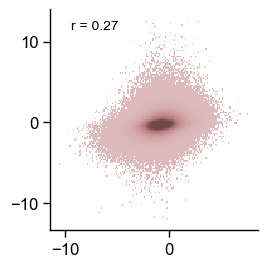

In [12]:
from matplotlib.colors import LinearSegmentedColormap
custom_colors = ['#ddbabb', '#d5adae', '#ce9fa1', '#c69294', '#bf8587', '#b7787b', '#9f676a', '#87575a', '#70484a']
custom_cmap = LinearSegmentedColormap.from_list("custom_b7787b", custom_colors)
compare_data = screens[5][0]['rep1'].reporter_guide_matrix.stack().to_frame("subsampled 5 lineages").merge(
    screen_rep2.reporter_guide_matrix.stack().to_frame("full"), how="outer",
    left_index=True, right_index=True)
sns.displot(data=compare_data, x="full", y="subsampled 5 lineages", cmap=custom_cmap,
            rasterized=True, bins=150, pmax=0.8, height=3)
r = compare_data.corr().iloc[0,1]
plt.text(0.1, 0.95, f'r = {r:.2f}', transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top')
plt.ylim(None, 14)
plt.xlabel("")
plt.ylabel("")
plt.yticks([-10, 0, 10])
# plt.savefig("5_lineages_rep1_reporter_activity_comparison_rep2_original.svg", bbox_inches='tight')

Text(12.96944444444445, 0.5, '')

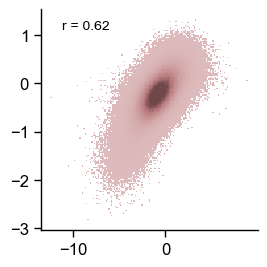

In [13]:
compare_data_pcp = screens[5][0]['rep1'].reporter_guide_matrix_pcp.stack().to_frame("subsampled 5 lineages").merge(
    screen_rep2.reporter_guide_matrix.stack().to_frame("full"), how="outer",
    left_index=True, right_index=True)
sns.displot(data=compare_data_pcp, x="full", y="subsampled 5 lineages", cmap=custom_cmap,
            rasterized=True, bins=150, pmax=0.8, height=3)
r = compare_data_pcp.corr().iloc[0,1]
plt.text(0.1, 0.95, f'r = {r:.2f}', transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top')
plt.xlabel("")
plt.ylabel("")
# plt.savefig("5_lineages_rep1_reporter_activity_comparison_rep2_pcp.svg", bbox_inches='tight')

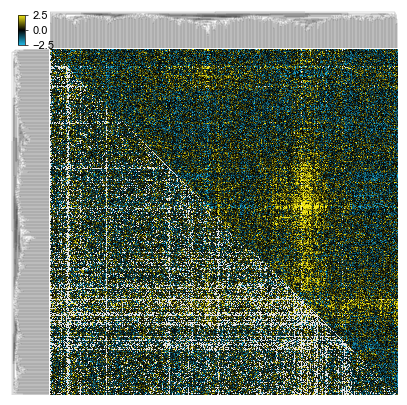

In [14]:
fig = plot_half_matrices(
    screen_rep2.z_reporter_GI, screens[5][0]['rep1'].z_reporter_GI,
    puro_AP1_screen.reporter_Z,
    cmap='BlueYellow',
    dendrogram_linewidth=0.1,
    figsize=(5, 5),
    ticklabels=False,
    color_scale=2.5
)
# fig.savefig("downsampled_5lineages_compare.svg", bbox_inches="tight")

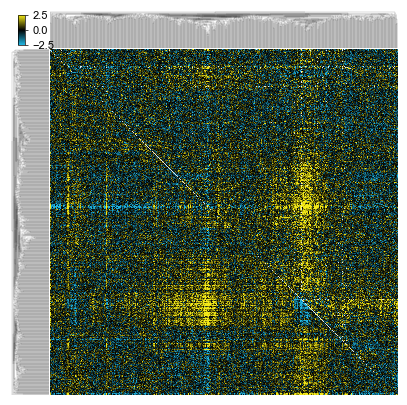

In [15]:
fig = plot_half_matrices(
    screen_rep2.z_reporter_GI, screens[5][0]['rep1'].z_reporter_GI_pcp,
    puro_AP1_screen.reporter_Z,
    cmap='BlueYellow',
    dendrogram_linewidth=0.1,
    figsize=(5, 5),
    ticklabels=False,
    color_scale=2.5
)
# fig.savefig("downsampled_5lineages_pcp_compare.svg", bbox_inches="tight")

### Internal validation - compare downsampled between replicates

In [16]:
original_corrcoefs_df = pd.DataFrame(original_corrcoefs)
pcp_corrcoefs_df = pd.DataFrame(pcp_corrcoefs)

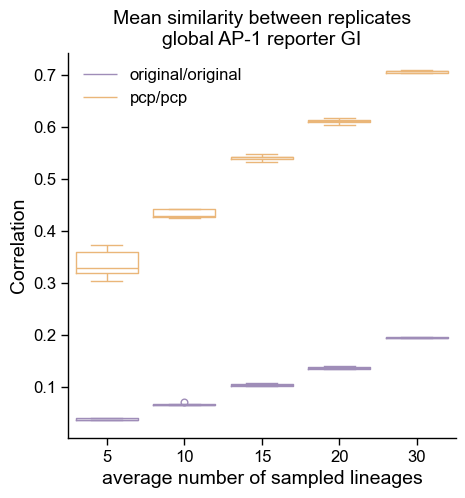

In [17]:
fig = plt.figure(figsize=(5, 5))
sns.boxplot(data=original_corrcoefs_df, fill=False, color="#9f8db8", linewidth=1, label="original/original")
sns.boxplot(data=pcp_corrcoefs_df, fill=False, color="#eab679", linewidth=1, label="pcp/pcp")
plt.title('Mean similarity between replicates\nglobal AP-1 reporter GI', fontsize=14)
plt.xlabel('average number of sampled lineages')
plt.ylabel('Correlation')
sns.despine()
plt.legend(frameon=False)
plt.show()
# fig.savefig("subsampling_reporter_global_GI_reps.svg", bbox_inches="tight")